# The SIFT Pipeline

In this exercise, we will fill in missing parts of an implementation of SIFT. Using your knowledge of SIFT from the lecture you will need to complete the `#TODO` sections in the code in order to make the pipeline run.

Once your implementation is complete you can compare the results with that of the implementation from scikit-image below.



We have provided a few helper methods to make implementing the full SIFT pipeline a bit easier, and you may make use of the `convolve` and `zoom` functions from the `scipy.ndimage` library. You can also refer to the original SIFT paper for more details: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import convolve, zoom

# Some helper methods for opening and plotting images, defined in helper.py
from helper import helper

# Define the floating point epsilon as 1e-7
EPS = 1e-7

# The blur level which we want the first image of the octave to have
sigma=1.6
# The number of intervals per octave, after this many images the blur level will have doubled (or halved if we are going down in scale)
num_intervals=3
# The number of levels (octaves) in the image pyramid
n_octaves=4
# A buffer to ensure that the image is large enough to be blurred by the largest kernel, and that we can extract descriptors from the keypoints
image_border_width=8


We will find keypoints on two aerial images from the Val d'Arpette in Switzerland, `img_a` and `img_b`, which overlap on a part of the image. 


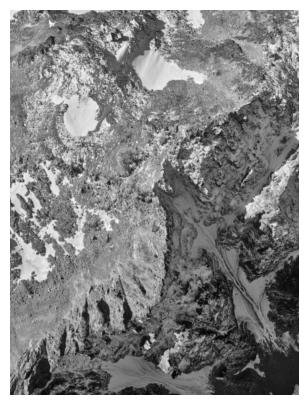

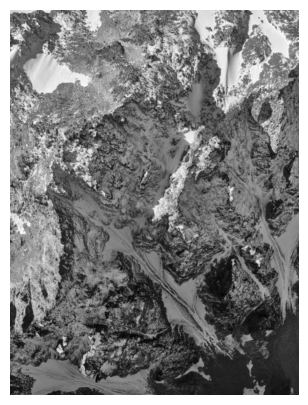

In [15]:
img_a = helper.open_base_image('imga.jpg')
img_b = helper.open_base_image('imgb.jpg')

helper.imshow(img_a)
helper.imshow(img_b)


## 1. Scale Space and the Image Pyramid

We will start focusing on implementing all the ingredients of keypoint detection exemplified on `img_a`. The first step in the SIFT pipeline is creating the scale space and image pyramid. In this section you'll implement the functions to do exactly that. 

### 1.1 The pyramid of Gaussians

The first step of the SIFT keypoint detector is creating a pyramid of Gaussian images which consists of `num_octaves` levels of images at different scales (blur levels). The concept of an octave in SIFT is the same as that in music: After `num_intervals + 1` steps the frequency of the blur should double as we move up the scale space. 

This `num_intervals + 1` image then becomes the first image in the next octave of the scale space by halving the image size (downscale by 2). The image below illustrates this concept.

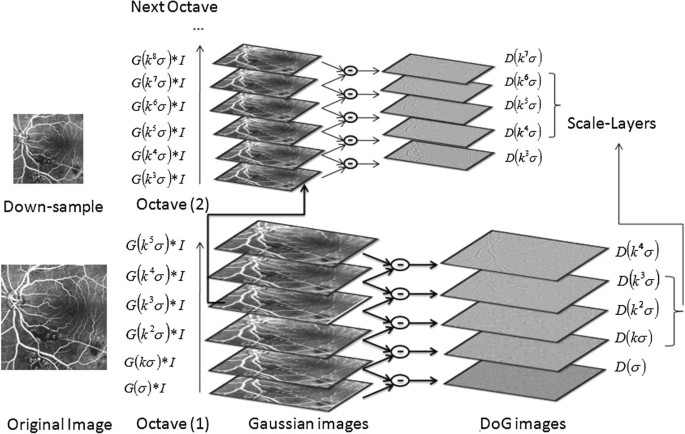

In [16]:
# NOTE: Use this function to generate the Gaussian kernels you need
def gaussian_filter(sigma):
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
    return g/g.sum()

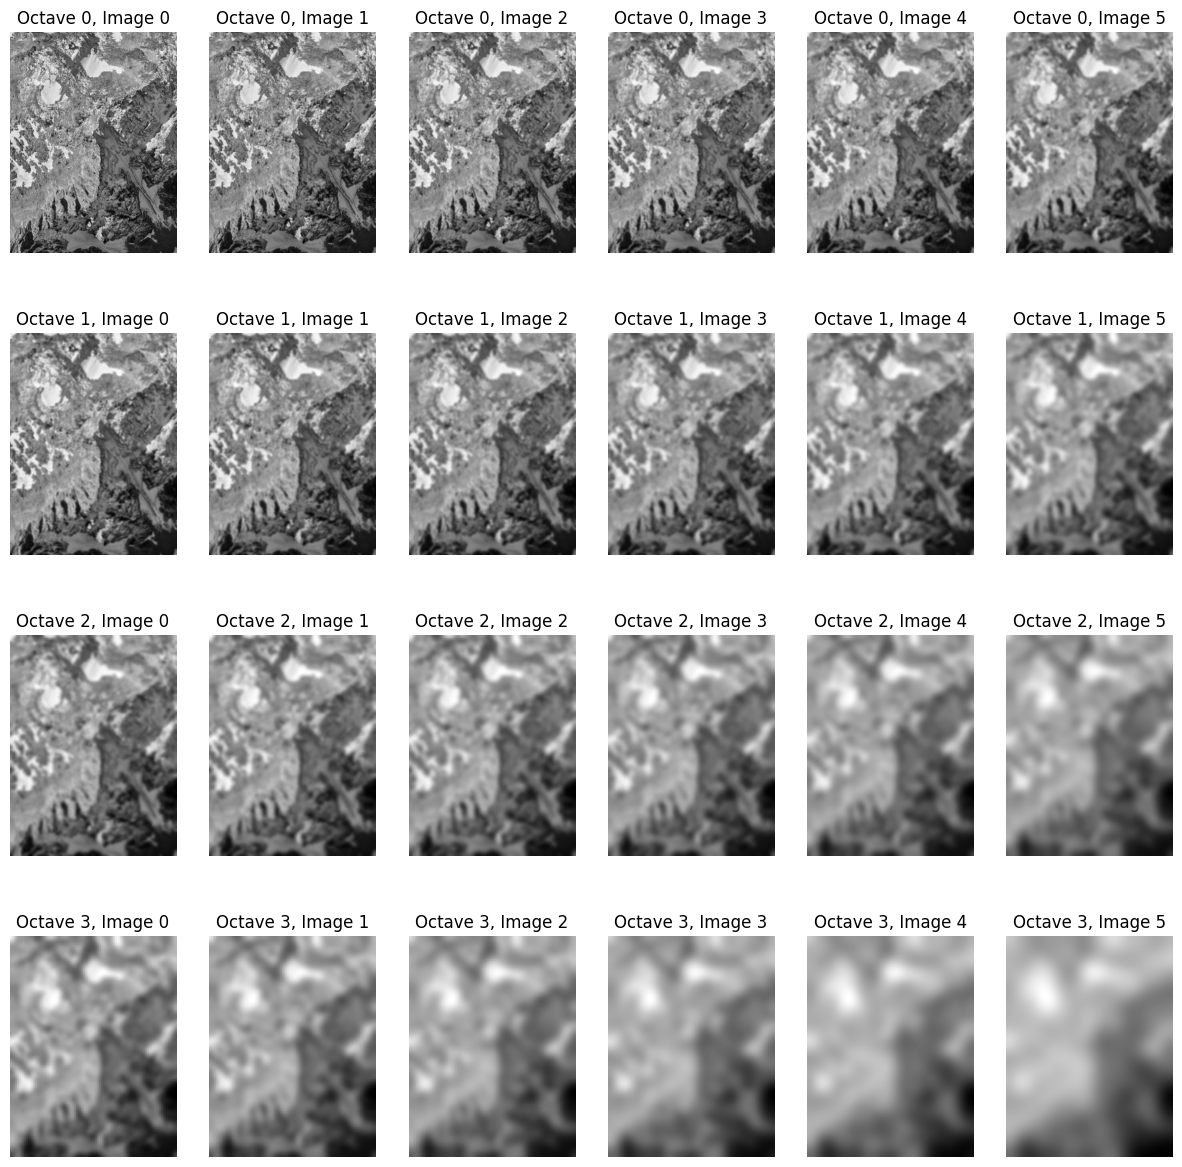

In [37]:
def generate_gaussian_octave(image, sigma=1.6, num_intervals=3):
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Halve the image size by taking every other pixel
    img_half = image[::2, ::2]
    ###### END YOUR CODE HERE ######

    # k is the sigma multiplier that means num_interval applications of it will lead to a doubling in the sigma of the Gaussian blur
    k = 2 ** (1.0 / num_intervals)

    # Compute the effective blur level for each scale in the octave, we need 2 more blur levels than the number of intervals to ensure that we can create the DoG for the first and last images too
    sigmas = [sigma * (k ** i) for i in range(num_intervals + 3)]
    
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Create a list of Gaussian blur kernels which will be applied at each layer in the pyramid, ensuring that by the num_interval+1 image will have
    # double the blur of the first image in the octave
    ###### HINT 1: To get the amount of blur to go from one image to the next, you can use the following formula: delta_sigma[i] = sqrt(sigmas[i]^2 - sigmas[i-1]^2)
    ###### HINT 2: You can use the gaussian_filter function defined above and your computed sigma values to generate the kernels
    delta_sigmas = [np.sqrt(sigmas[i]**2 - sigmas[i-1]**2) for i in range(1, len(sigmas))]
    kernels = [gaussian_filter(ds) for ds in delta_sigmas]
    ###### END YOUR CODE HERE ######

    # We know the first image already has the correct blur level, so store it as the first image in the octave
    octave = [img_half]

    ###### YOUR CODE GOES HERE ######
    ###### TODO: Generate the octave by applying the Gaussian blur kernels you created above to the previous image in the octave
    ###### HINT: Use the convolve function from scipy.ndimage to apply the kernels to the image
    for kernel in kernels:
        next_image = convolve(octave[-1], kernel)
        octave.append(next_image)
    ###### END YOUR CODE HERE ######

    return octave


def generate_gaussian_pyramid(base_image, n_octaves, sigma=1.6, num_intervals=3):
    """
    Generates the Gaussian pyramid for the SIFT scale space. 
    The Gaussian pyramid is a 3D array where the first dimension is the octave, the second dimension is the interval, and the third dimension is the image itself.
    """
    gaussian_images = []

    for _ in range(n_octaves):
        # check if base_image 2d array is the same as org_img
        octave = generate_gaussian_octave(base_image, sigma, num_intervals)
        gaussian_images.append(np.stack(octave, axis=2))
        ###### YOUR CODE GOES HERE ######
        ###### TODO: Take the image which has double the blur in the current octave as the base image for the next octave
        base_image = octave[num_intervals]
        ###### END YOUR CODE HERE ######

    return gaussian_images


gaussian_pyramid = generate_gaussian_pyramid(img_a, n_octaves, sigma, num_intervals)

helper.plot_pyramid(gaussian_pyramid)

### 1.2 The Difference of Gaussians (DoG) pyramid 

Once the Gaussian image pyramid has been created, we can create the DoG pyramid. Each octave of the DoG is created by taking the difference between consecutive scales in the Gaussian pyramid. See the previous image for more details.

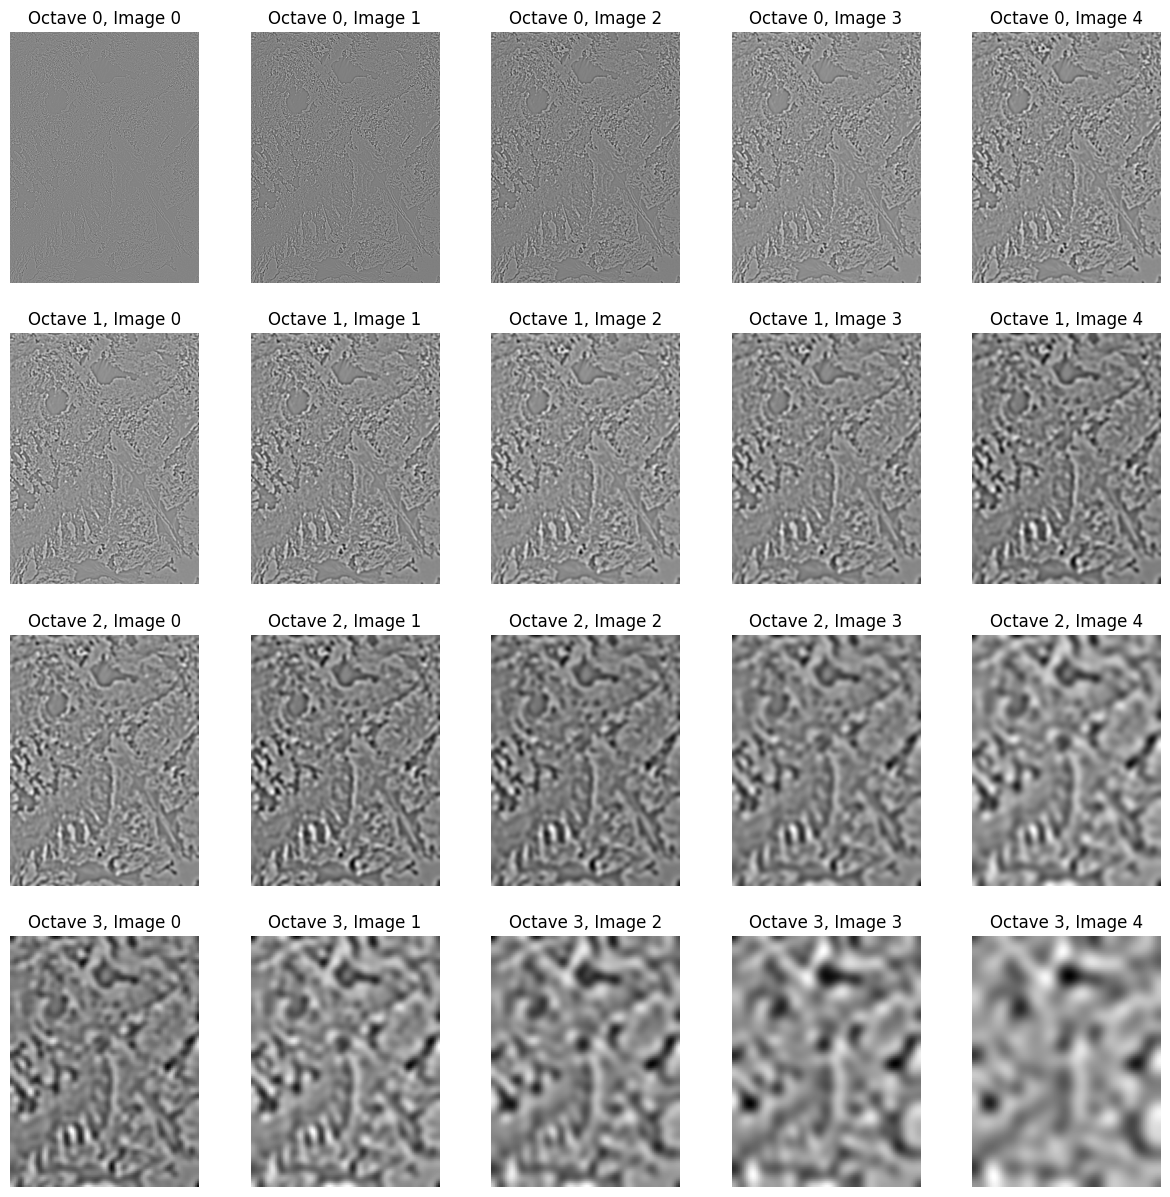

In [40]:
def generate_diff_of_gaussian_pyramid(gaussian_pyramid):
    pyramid = []

    ###### YOUR CODE GOES HERE ######
    ###### TODO: Iterate over the gaussian pyramid and take the difference between consecutive images DoG_1 = (G_2 - G_1) to form the DoG pyramid
    ###### pyramid should be a list of numpy arrays where each array is a HxWx(num_intervals+2) array of the DoG images for a given octave
    for octave in gaussian_pyramid:
        dog_octave = np.zeros((octave.shape[0], octave.shape[1], octave.shape[2] - 1))
        for i in range(1, octave.shape[2]):
            dog_octave[:, :, i-1] = octave[:, :, i] - octave[:, :, i-1]
        pyramid.append(dog_octave)
    ###### END YOUR CODE HERE ######

    return pyramid

dog_pyramid = generate_diff_of_gaussian_pyramid(gaussian_pyramid)

helper.plot_pyramid(dog_pyramid)


### 1.3 Finding Keypoints

In its simplist form this is done by iterating through each layer of the DoG pyramid, taking three consecutive images at a time. Remember that all images in a layer have the same size and only differ by the amount of blur applied. In each triplet of images, we look for pixels in the middle image that are greater than or less than all of their 26 neighbors: 8 neighbors in the middle image, 9 neighbors in the image below, and 9 neighbors in the image above.

Thus identifying keypoints can be defined as looking at `3x3x3` windows (row, col, scale) and determining if the following rules hold:
1) The magnitude of the center pixel is larger than a `threshold`
2) The center pixel is larger than or smaller than all other neighbouring pixels in the `3x3x3` patch.

![image.png](https://docs.opencv.org/4.x/sift_local_extrema.jpg)

In [41]:
def is_pixel_an_extrema(dog_patch, threshold):
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Given a 3x3x3 DoG patch determine if the center pixel is an extrema (potential keypoint) if it is return True else return False
    # Check if the center pixel is the maximum or minimum of the 3x3x3 patch
    center = dog_patch[1, 1, 1]
    if center > threshold:
        return np.all(center >= dog_patch)
    elif center < -threshold:
        return np.all(center <= dog_patch)
    return False

    ###### END YOUR CODE HERE ######

# We run some simple test to verify that is_pixel_an_extrema works as intended
test_window_a = np.ones((3, 3, 3))
test_window_b = np.copy(test_window_a)
test_window_b[1][1][1] += 1

assert is_pixel_an_extrema(test_window_a, 1)==False
assert is_pixel_an_extrema(test_window_b, 1)==True
assert is_pixel_an_extrema(-test_window_b, 1)==True
assert is_pixel_an_extrema(-test_window_b/3, 1)==False

In [44]:
def find_scale_space_extrema(dog_pyramid, num_intervals, image_border_width):
    """
    Finds the keypoints in the SIFT scale space by finding the local extrema in the DoG pyramid. 
    NOTE: We iterate over the pixels in the image that are not on the border (image_border_width pixels from the border) 
    otherwise we won't be able to compute descriptors for those keypoints!
    """
    potential_keypoints = []

    # The threshold for the magnitude of a pixel to be considered as a potential keypoint (the first check)
    threshold = (0.5 * 0.03 / num_intervals) # From OpenCV implementation

    for octave_idx, dog_octave in enumerate(dog_pyramid):
        for scale_idx in range(1, dog_octave.shape[2] - 1):
            ###### YOUR CODE GOES HERE ######
            ###### TODO: Loop over all pixels in the image that are not on the border (image_border_width pixels from the border) and check if the pixel is an extrema
            ###### by calling the is_pixel_an_extrema function you implemented above on the 3x3x3 patch of the DoG image centered at the pixel
            ###### Each keypoint should be added to the `potential_keypoints` list as a tuple of (octave_idx, row_idx, col_idx, scale_idx)
            for row_idx in range(image_border_width, dog_octave.shape[0] - image_border_width):
                for col_idx in range(image_border_width, dog_octave.shape[1] - image_border_width):
                    patch = dog_octave[row_idx-1:row_idx+2, col_idx-1:col_idx+2, scale_idx-1:scale_idx+2]

                    if is_pixel_an_extrema(patch, threshold):
                        potential_keypoints.append((octave_idx, row_idx, col_idx, scale_idx))
            ###### END YOUR CODE HERE ######

    return potential_keypoints

potential_keypoints = find_scale_space_extrema(dog_pyramid, num_intervals, image_border_width)
assert len(potential_keypoints) > 1000

### 1.4 Localize potential keypoints

In this step we refine the keypoint location by fitting a quadratic surface to the 3x3x3 patch around the keypoint, and then perform an iterative optimization to find the subpixel location of the keypoint. As this is quite a complex function we have done the main implementation for you. 

The final stage of the keypoint localization is to use the Harris Cornerness test to discard keypoints which are less optimal (located on edges).

Your contribution to this section will be to implement the functions needed to compute the gradient and the Harris corner test.

![image.png](https://docs.opencv.org/3.4/harris_region.jpg)

In [ ]:
def compute_gradient_at_center_pixel(dog_patch):
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Compute the gradient at the center pixel of the 3x3x3 patch. Keep in mind you will have 3 gradients [dx, dy, ds] – one in each dimension. 
    ###### Use the finite difference method to compute the gradient (y0-y2)/(x0-x2)
    ###### HINT: Rows are the y dimension, columns are the x dimension, and the depth is the s dimension
    dy = 
    dx = 
    ds = 
    ###### END YOUR CODE HERE ######

    return np.array([dx, dy, ds])

In [ ]:
def is_harris_corner(xy_hessian, R=10):
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Compute the trace and determinant of the Hessian matrix
    xy_hessian_trace = 
    xy_hessian_det = 
    ###### END YOUR CODE HERE ######

    # In the case of a flat region, the determinant of the Hessian matrix is 0 so we discard the keypoint
    if xy_hessian_det <= 0:
        return False
    
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Compute the ratio between the smallest and largest eigenvalue of the Hessian matrix and return False if the ratio is greater than R (10 in the original SIFT paper)
    ###### HINT: trace(H) = a + b and det(H) = ab, where a and b are the two eigenvalues - how can this be used to get the ratio between a and b?
    ###### you will need to use this HINT to derive a threshold based on R which you can use to filter out keypoints
    
    ###### END YOUR CODE HERE ######

    return True

In [ ]:
# There is no need to modify this function - it is used to compute the Hessian matrix at the center pixel of the 3x3x3 patch
def compute_hessian_at_center_pixel(dog_patch):
    dss = dog_patch[1, 1, 2] - 2 * dog_patch[1, 1, 1] + dog_patch[1, 1, 0]
    dxx = dog_patch[1, 2, 1] - 2 * dog_patch[1, 1, 1] + dog_patch[1, 0, 1]
    dyy = dog_patch[2, 1, 1] - 2 * dog_patch[1, 1, 1] + dog_patch[0, 1, 1]

    dxs = (dog_patch[1, 2, 2] - dog_patch[1, 2, 0] - dog_patch[1, 0, 2] + dog_patch[1, 0, 0]) / 4.0
    dys = (dog_patch[2, 1, 2] - dog_patch[2, 1, 0] - dog_patch[0, 1, 2] + dog_patch[0, 1, 0]) / 4.0
    dxy = (dog_patch[2, 2, 1] - dog_patch[2, 0, 1] - dog_patch[0, 2, 1] + dog_patch[0, 0, 1]) / 4.0

    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

In [ ]:
# Some test cases to make sure your is_harris_corner function is working correctly
test_hessian = np.array([[1, 0], [0, 1]])
assert is_harris_corner(test_hessian, R=10) == True

test_hessian = np.array([[1, 0], [0, 0]])
assert is_harris_corner(test_hessian, R=10) == False

test_hessian = np.array([[1, 0], [0, 0.1]])
assert is_harris_corner(test_hessian, R=10) == False

test_hessian = np.array([[1.1, 0.3], [0.3, 1.0]])
assert is_harris_corner(test_hessian, R=10) == True


In [ ]:
# We have implemented this function for you, you do not need to modify this block

def localize_keypoint(keypoint, dog_pyramid, num_attempts_until_convergence=5, image_border_width=8):
    """
    Refines the location of the keypoint by fitting a quadratic surface to the 3x3x3 patch around the keypoint and finding the maximum of the quadratic surface.
    This is done by solving the linear system of equations: H * x = -J, where H is the Hessian matrix, J is the gradient, and x is the update vector.
    """
    octave_idx, row_idx, col_idx, scale_idx = keypoint

    # Run the iterative refinement of the keypoint location until convergence (less than 0.5 pixel update)
    for i in range(num_attempts_until_convergence):
        dog_patch = dog_pyramid[octave_idx][row_idx-1:row_idx+2, col_idx-1:col_idx+2, scale_idx-1:scale_idx+2]
        J = compute_gradient_at_center_pixel(dog_patch)
        H = compute_hessian_at_center_pixel(dog_patch)
        extremum_update = -np.linalg.lstsq(H, J, rcond=None)[0]

        # If the gradient update is less than 0.5 pixels in all dimensions, we have converged to the correct keypoint location
        if np.all(np.abs(extremum_update) < 0.5):
            break

        col_idx += int(round(extremum_update[0]))
        row_idx += int(round(extremum_update[1]))
        scale_idx += int(round(extremum_update[2]))

        # If the keypoint is outside the image border, we discard it
        if col_idx < image_border_width or col_idx > dog_pyramid[octave_idx].shape[1] - image_border_width or \
            row_idx < image_border_width or row_idx > dog_pyramid[octave_idx].shape[0] - image_border_width or \
            scale_idx < image_border_width or scale_idx > dog_pyramid[octave_idx].shape[2] - image_border_width:
            return None

    function_value_at_updated_extremum = dog_patch[1, 1, 1] + 0.5 * np.dot(J, extremum_update)

    # The threshold of 0.03 is from the original SIFT paper to ensure we discard keypoints with low contrast
    if np.abs(function_value_at_updated_extremum) > 0.03:
        # The next step is to eliminate edge responses by computing the ratio of the smallest to largest eigenvalue of the Hessian matrix
        # This is the same as done for the Harris corner detector
        xy_hessian = H[0:2, 0:2]

        R = 10 # The maximum ratio between the smallest and largest eigenvalue of the Hessian matrix
        if not is_harris_corner(xy_hessian, R):
            return None

        # If the keypoint passes all the tests, we return it
        return octave_idx, row_idx + extremum_update[1], col_idx + extremum_update[0], scale_idx + extremum_update[2]

    return None

def localize_keypoints(potential_keypoints, dog_pyramid, num_attempts_until_convergence=5, image_border_width=5):
    localized_keypoints = []

    for keypoint in potential_keypoints:
        localized_keypoint = localize_keypoint(keypoint, dog_pyramid, num_attempts_until_convergence, image_border_width)
        if localized_keypoint is not None:
            localized_keypoints.append(localized_keypoint)

    return localized_keypoints

keypoints = localize_keypoints(potential_keypoints, dog_pyramid, num_intervals)


# 2. Determine the keypoint orientation

The final step in the feature detection process is to determine the main orientation of the feature point. This is done so that we can use it to rotate the image before computing the descriptor. It is this which makes SIFT rotation invariant

In [ ]:
def get_gradient_magnitude_and_theta(patch):
    ###### YOUR CODE GOES HERE ######
    ###### TODO: Given a 3x3 patch, compute the gradient at the center pixel and the orientation of the gradient in degrees
    ###### HINT: magnitude = sqrt(dx^2 + dy^2) and theta = arctan2(dy, dx) in radians (use np.rad2deg to convert to degrees)
    dx = 
    dy = 
    magnitude = 
    theta_deg = 
    ###### YOUR CODE ENDS HERE ######
    return magnitude, theta_deg

In [ ]:
def compute_orientation_for_keypoints(keypoints, gaussian_pyramid, sigma=1.6, num_bins=36, num_intervals=3):
    """
    Computes the dominant orientation for each keypoint by constructing a histogram of gradient orientations around the keypoint.
    The radius to compute gradients over is 3 * gaussian_sigma.
    """
    keypoints_with_orientations = []

    for keypoint in keypoints:
        octave_idx, row_idx, col_idx, scale_idx = keypoint

        # The radius to compute gradients over is 3 * gaussian_sigma (from original SIFT paper)
        k = 2 ** (1.0 / num_intervals)
        scale = 1.5 * sigma * (k ** scale_idx)
        #  The radius is 3*scale as this means that 99.7% of the Gaussian weight distribution is within this radius (from original SIFT paper)
        radius = int(round(3 * scale))

        # A weight which is assigned to each gradient orientation based on the distance from the keypoint
        # It is simply a Gaussian distribution with mean 0 and standard deviation 1.5 * the scale of the keypoint
        weight_factor = -0.5 / (scale ** 2)

        # We extract a 2*radius+1 x 2*radius+1 patch around the keypoint
        ri, ci, si = int(row_idx), int(col_idx), int(scale_idx)
        L = gaussian_pyramid[octave_idx][ri-radius:ri+radius+1, ci-radius:ci+radius+1, si]
        hist = np.zeros(num_bins, dtype=np.float32)

        # We iterate over all the pixels in the patch and compute the gradient magnitude and orientation and add it to the histogram
        # We weight each magnitude by the Gaussian distribution with mean 0 and standard deviation 1.5 * the scale of the keypoint
        for x in range(1, L.shape[0]-1):
            for y in range(1, L.shape[1]-1):
                patch = L[x-1:x+2, y-1:y+2]
                m, theta = get_gradient_magnitude_and_theta(patch)
                weight = np.exp(weight_factor * ((x-radius)**2 + (y-radius)**2)) # This is just a Gaussian weight based on the distance from the keypoint

                ###### YOUR CODE GOES HERE ######
                ###### TODO: We find the bin in the histogram where the gradient orientation falls and add the Gaussian weighted magnitude to the bin
                hist_idx = 
                hist[hist_idx] += 
                ###### YOUR CODE ENDS HERE ######

        # We find the maximum value in the histogram
        max_value = np.max(hist)

        ###### YOUR CODE GOES HERE ######
        ###### TODO: We find all the bins in the histogram where the value is greater than or equal to 80% of the `max_value`. For each of these orientations
        ###### add a keypoint to the `keypoints_with_orientations` list in the format (octave_idx, row_idx, col_idx, scale_idx, orientation in degrees)
        ###### HINT: (bin_idx * num_bins/360) will give you the orientation in degrees
        for bin_idx in range(num_bins):
            if ...
                keypoints_with_orientations.append()
        ###### YOUR CODE ENDS HERE ######

    return keypoints_with_orientations

keypoints_with_orientation = compute_orientation_for_keypoints(keypoints, gaussian_pyramid)

## 3. Putting it all together

Using all the functions we defined previously we can put together the complete SIFT keypoint detection pipeline.

In general the computation of the SIFT descriptors is based on a similar gradient orientation histogram to that which you implemented to compute the feature orientation. A 16x16 pixel patch is extracted around each keypoint and divided into subcells of 4x4 pixels. The histogram of gradients (using 8 bins) is computed for each of these 4x4 cells and these histograms are concatendated into a 128-dim feature descriptor. However, due to time constraints we will skip the implementation of the SIFT descriptor and use scikit-image implementation later.

In [ ]:
# Convert the keypoints to the original image dimensions
def convert_features_to_image_size(features, image_shape):
    features_converted = []

    for feature in features:
        octave_idx, row_idx, col_idx, scale_idx, orientation = feature
        scale_factor = 2 ** octave_idx
        row_idx *= scale_factor
        col_idx *= scale_factor
        scale_idx *= scale_factor
        features_converted.append((row_idx, col_idx, scale_idx, orientation))

    return np.array(features_converted)

In [ ]:
def compute_SIFT_keypoints(image, sigma, num_intervals, n_octaves, image_border_width):
    # Compute the gaussian image pyramid
    gaussian_pyramid = generate_gaussian_pyramid(image, n_octaves, sigma, num_intervals)            
    # Compute the difference of gaussian image pyramid
    dog_pyramid = generate_diff_of_gaussian_pyramid(gaussian_pyramid)
    
    # Compute the keypoints
    potential_keypoints = find_scale_space_extrema(dog_pyramid, num_intervals, image_border_width)
    # Localize the keypoints
    keypoints = localize_keypoints(potential_keypoints, dog_pyramid, num_intervals)
    # Compute the dominant orientation for each keypoint
    keypoints = compute_orientation_for_keypoints(keypoints, gaussian_pyramid, sigma, num_intervals)
    # Convert the keypoints to the original image dimensions
    keypoints = convert_features_to_image_size(keypoints, image.shape)

    return keypoints

img_a = helper.open_base_image('imga.jpg')
img_b = helper.open_base_image('imgb.jpg')

a_kpts = compute_SIFT_keypoints(img_a, sigma, num_intervals, n_octaves, image_border_width)
b_kpts = compute_SIFT_keypoints(img_b, sigma, num_intervals, n_octaves, image_border_width)

helper.plot_image_and_keypoints(img_a, a_kpts, 'SIFT Keypoints - Image A')
helper.plot_image_and_keypoints(img_b, b_kpts, 'SIFT Keypoints - Image B')

# Using Scikit-Image SIFT Features

In this section we will use the Scikit-image implementation of SIFT to match keypoints between the images and compare the results to the keypoints we were able to match with our implementation above. 
The matched keypoints from this section will form the starting point for `Lab_04` so be sure to run the last block to save your results to a CSV file which you will use in the lab.

In [ ]:
from skimage.feature import match_descriptors, plot_matches, SIFT
descriptor_extractor = SIFT()

# Open the images and convert them to grayscale
img_a = helper.open_image('imga.jpg')
img_b = helper.open_image('imgb.jpg')

descriptor_extractor.detect_and_extract(img_a)
keypoints_a = descriptor_extractor.keypoints
descriptors_a = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img_b)
keypoints_b = descriptor_extractor.keypoints
descriptors_b = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_a, descriptors_b, max_ratio=0.5,
                              cross_check=True)
fig, ax = plt.subplots(figsize=(20,20))
plot_matches(ax, img_a, img_b, keypoints_a, keypoints_b, matches[:500], only_matches=True)

Use pandas to save the matches to a CSV file with the following format:

`col_img_a, row_img_a, col_img_b, row_img_b` 

In [ ]:
import pandas as pd
import numpy as np

df_matches = pd.DataFrame(np.concatenate([keypoints_a[matches[:,0]][:,(1,0)], keypoints_b[matches[:,1]][:,(1,0)]], 1), columns=['col_a', 'row_a', 'col_b', 'row_b'])
df_matches.to_csv('matches.csv', index=False)